---
title: "Supervised Learning"
format:
    html: 
        code-fold: true
---

In this section, the goal is to build machine learning models to investigate the drivers of our target variables: chronic absenteeism, dropout risk, and college persistence. We will create three different models: a regression, a binary classification, and a multivariate classification. For each, we will test various algorithms and identify the one that performs best.

I developed several functions to streamline the modeling process. These functions handle preprocessing, training, tuning, scoring the validation set, and scoring the test set.

1. *Preprocessing*: This function takes a dataframe, target column, and test size as inputs. It splits the data into training, validation, and test sets. The training set is used to train the models, the validation set is crucial for tuning hyperparameters, and the test set evaluates the model's performance on unseen data.

2. *Train*: This function accepts X_train, y_train, learning_task_type, model_type, and ** kwargs. The learning_task_type should be either 'classification' or 'regression', while model_type specifies the algorithm to be used. The ** kwargs parameter allows additional arguments to be passed to the algorithm, which is used once the model is tuned.

3. *Tune*: This function takes a model, X_train, y_train, param_grid, and an optional scoring parameter. It uses cross-validation to tune hyperparameters. Predefined parameter grids for random forest and gradient boosting models allow the function to perform a grid search over specified values to identify optimal parameters. The scoring parameter specifies the metric to maximize, depending on the task.

4. *Validation Scoring*: This function evaluates the model's performance on the validation set to guide hyperparameter tuning. It accepts learning_task_type, model, X_val, and y_val as inputs. For regression tasks, it outputs metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R². For classification tasks, it provides a confusion matrix.

5. *Evaluate Test*: This is the final step, where the model's performance is evaluated on the test set. The function accepts learning_task_type, model, X_test, and y_test as inputs. It outputs relevant regression or classification metrics for the tuned mode

In [565]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV
from imblearn.over_sampling import SMOTE

import statsmodels.api as sm
from scipy import stats

In [2]:
df = pd.read_csv('../../data/processed-data/processed_df.csv', index_col=None)
df_regression = pd.read_csv('../../data/processed-data/df_subset_regression.csv', index_col=None)

In [4]:
# Drop categorical and identifier columns we dont need
df.drop(columns=['DBN', 'School Name', 'District', 'zip code', 'Borough'], inplace=True)
#drop columns that cause perfect multicollinearity
df_clean = df.drop(['Median Household Income',"Percent Bachelor's Degree or Higher (25+)",'Percent No High School (25+)','Student Percent - Other', 'Percent Female','Percent College Ready based on SAT Math'], axis=1)

In [5]:
def preprocessing(df, target_column, test_size=0.2):
       """Splits the data into training and test sets."""
       X = df.drop(columns=[target_column])
       y = df[target_column]
       #split into training, validation, test set
       X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
       X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=test_size, shuffle=True)
       #standardize
       scaler = StandardScaler()
       X_train = scaler.fit_transform(X_train)
       X_val = scaler.transform(X_val)
       X_test = scaler.transform(X_test)
       return X, y, X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
def train(X_train, y_train, learning_task_type, model_type, **kwargs):
    """Trains a machine learning model."""
    if learning_task_type == 'regression':
        if model_type == 'random_forest':
            model = RandomForestRegressor(**kwargs)
        elif model_type == 'lasso_regression':
            model = Lasso(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingRegressor(**kwargs)
        else:
            raise ValueError("Invalid regression model type: Choose 'random_forest', 'linear_regression', or 'gradient_boosting'.")
    elif learning_task_type == 'classification':
        if model_type == 'random_forest':
            model = RandomForestClassifier(**kwargs)
        elif model_type == 'gradient_boosting':
            model = GradientBoostingClassifier(**kwargs)
        else:
            raise ValueError("Invalid classification model type: Choose 'random_forest' or 'gradient_boosting'.")
    else:
        raise ValueError("Learning types: ['classification','regression'] \n Model types: ['linear_regression','random_forest','gradient_boosting']")
    model.fit(X_train, y_train)
    return model

In [7]:
def tune(model, X_train, y_train, param_grid, scoring=None):
    """Performs hyper-parameter tuning."""
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_params_}")
    return model

In [8]:
def validation_eval(learning_task_type, model, X_val, y_val):
    y_pred = model.predict(X_val)

    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_val, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        R2 = r2_score(y_val, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
    
    elif learning_task_type == 'classification':
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")

    return y_pred

In [9]:
def evaluate_test(learning_task_type, model, X_test, y_test):
    """Evaluates the model on new data or the test set."""
    y_pred = model.predict(X_test)
    
    if learning_task_type == 'regression':
        MAE = mean_absolute_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        R2 = r2_score(y_test, y_pred)

        print(f"Mean Absolute Error (MAE): {MAE:.4f}")
        print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
        print(f"R-squared: {R2:.4f}")
        
    elif learning_task_type == 'classification':
        print("Classification Report:", classification_report(y_test, y_pred))
    else:
        raise ValueError("Unsupported learning task type: 'regression' or 'classification'")
    
    return y_pred

In [10]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [5, 15, 20],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False] 
}

boost_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 10], 
    'max_features': ['sqrt', 'log2']  
}

## Regression

Regression is a supervised learning task used to identify relationships between continuous data. In this task, we have one variable of interest, referred to as the dependent variable, and several independent features, which we hypothesize are related to the dependent variable. The strength of these relationships is quantified by the coefficients of the independent variables.

In this case, our goal is to identify the drivers of chronic absenteeism. By analyzing these outputs, schools can implement targeted interventions to reduce chronic absenteeism in New York City Public Schools.

**Target Variable:** *Percent of Students Chronically Absent*

### LASSO Regression

LASSO, or Least Absolute Shrinkage and Selection Operator is a regularization technique known as L1 Regularization. It is a good option in this case because of its ability to work with high dimensional data. We can think of it like a rope lasso that is thrown around all the features and filters out the variables that do not contribute to our model, by pushing their coefficients to 0. It does this by introducing a regularization hyperparamter, which we will tune to help shrink the coefficicents. This will help us perform feature selection automatically, and find the importance of the terms we are left with.


In [235]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_clean, target_column='Percent of Students Chronically Absent')

In [236]:
model = train(X_train, y_train, 'regression', 'lasso_regression', alpha=0.01)
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.1010
Root Mean Squared Error (RMSE): 0.1250
R-squared: 0.3138


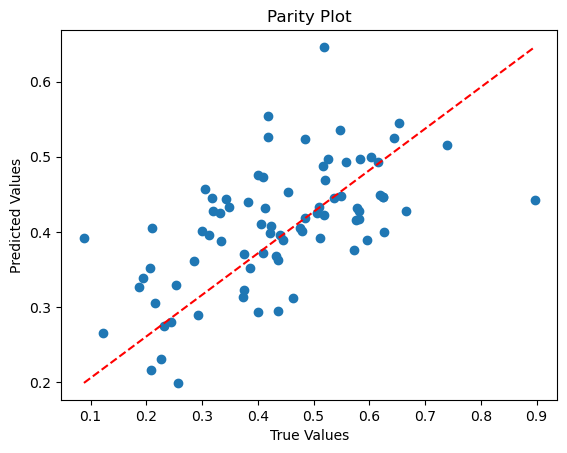

In [237]:
plt.scatter(y_val, y_pred)
plt.plot([min(y_val), max(y_val)], [min(y_pred), max(y_pred)], color='red', linestyle='--') 
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

To tune our hyperparamter, we will use scikit-learn's cross validation tool specifically for Lasso regression, LassoCV to find the optimal choice for alpha

In [238]:
lasso_cv = LassoCV(alphas=[0.1, 0.01, 0.05, 0.001, 0.005, 0.0005, 0.0001], cv=5)
lasso_cv.fit(X_train, y_train)
print(f"Optimal alpha: {lasso_cv.alpha_}")

Optimal alpha: 0.005


In [239]:
model = train(X_train, y_train, 'regression', 'lasso_regression', alpha=0.001)
y_pred = evaluate_test('regression', model, X_test, y_test)

Mean Absolute Error (MAE): 0.0829
Root Mean Squared Error (RMSE): 0.1053
R-squared: 0.6077


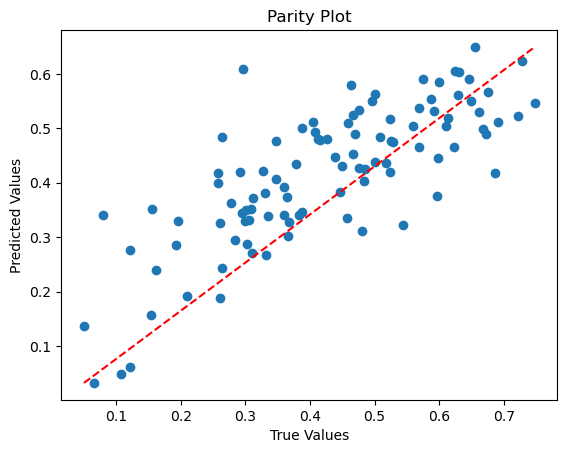

In [240]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red', linestyle='--') 
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Now, using the absolute value of the coefficients, we can visualize the features that are most relevant to our target variable

<Figure size 2000x1500 with 0 Axes>

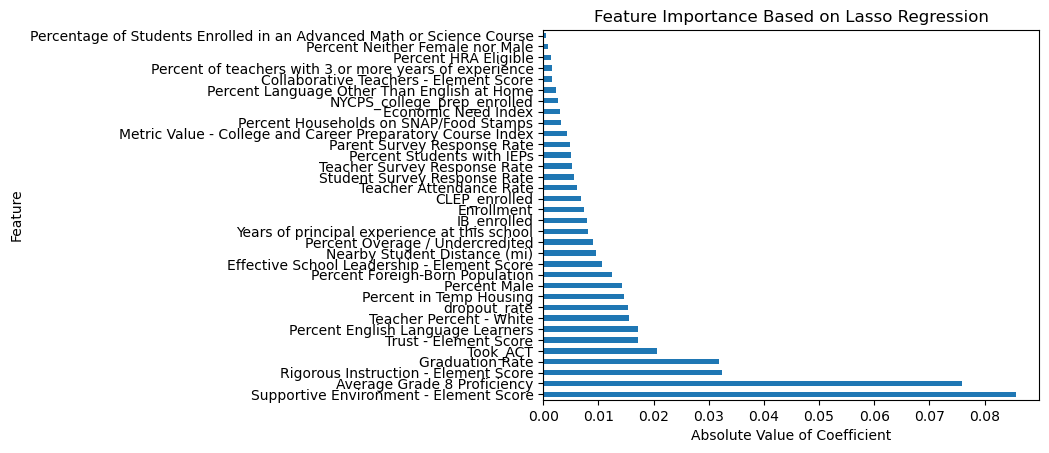

In [248]:
feature_names = X.columns
coefs = model.coef_

coefs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})


coefs_df['abs_val_coef'] = coefs_df['Coefficient'].abs()
coefs_df = coefs_df.sort_values(by='abs_val_coef', ascending=False)

coefs_df = coefs_df.loc[coefs_df['abs_val_coef']>0]

plt.figure(figsize=(15, 15))
coefs_df.plot(kind='barh', x='Feature', y='abs_val_coef', legend=False)
plt.xlabel('Absolute Value of Coefficient')
plt.title('Feature Importance Based on Lasso Regression')
plt.show()


**Result:** After tuning the alpha of the model, the fit improved to 61%, with a decrease in RMSE and MAE. In addition, we can gain valuable insights from the Feature Importance graph, with Supportive Environment score emerging as the most important variable in our model. This score reflects how well a school fosters a supportive, challenging environment for students [@NYCPublicSchoolsInfoHub_2024]. The next most important feature is Average Grade 8 Proficiency. This metric emphasizes how important it is for children to be on the right track from a young age. The third key factor was Rigorous Instruction score, which reflects how engaging the curriculum and how effectively it promotes critial-thinking skills [@NYCPublicSchoolsInfoHub_2024]. Additionally, significant socioeconomic factors contributing to chronic absenteeism included Percent English Language Learners and Percent in Temporary Housing.

### Random Forest Regression

Random Forest is a supervised learning task that is an ensemble of many decision trees. Simply, decision trees work by starting at a root node and split depending on questions asked at each successive node. Random Forest is just many decision trees working together. It is superior to single decision trees because it prevents overfitting by averaging the outcome of the individual trees to get the final result. In addition, it is less sensitive to multicollinearity and normalization than other regression methods and can learn non-linear boundaries.

There are a few important hyperparamters to tune in random forest regression. This includes n_estimators (the number of trees in the forest), max_depth (the maximum depth or number of splits each tree can have), max_features (how many features are considered for splits), and bootstrap (whether bootstrapping (resampling with replacement) should be used) [@noauthor_randomforestregressor_nodate]

When bootstrapping is used, this is considered a bagging method (Bootstrap Aggregating).

We will apply the Random Forest Regressor and evaluate whether it improves our results.

In [426]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df_regression, 'Percent of Students Chronically Absent')

In [427]:
model = train(X_train, y_train, 'regression', 'random_forest')
print('Validation Scores')
y_pred = validation_eval('regression',model,  X_val, y_val)

Validation Scores
Mean Absolute Error (MAE): 0.0860
Root Mean Squared Error (RMSE): 0.1136
R-squared: 0.5295


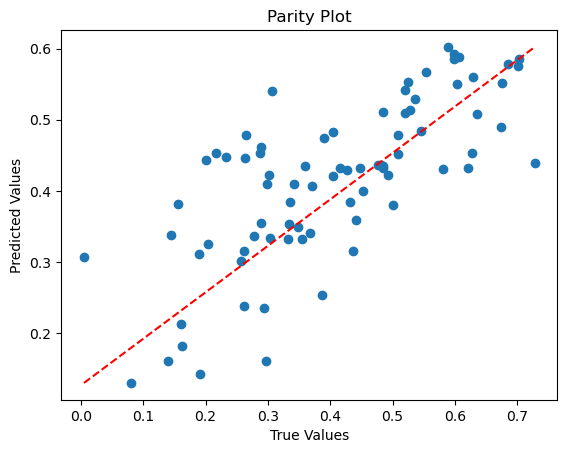

In [428]:
plt.scatter(y_val, y_pred)
plt.plot([min(y_val), max(y_val)], [min(y_pred), max(y_pred)], color='red', linestyle='--') 
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

Tune and Retrain Model

In [429]:
tune(model, X_train, y_train, rf_param_grid, scoring='neg_mean_squared_error')

Best params: {'bootstrap': True, 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}


RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=200)

In [431]:
model = train(X_train, y_train, 'regression', 'random_forest', bootstrap = True, max_depth= 15, max_features= 'log2', n_estimators= 200)

In [432]:
print('Test Evaluation')
y_pred = evaluate_test('regression', model, X_test, y_test)

Test Evaluation
Mean Absolute Error (MAE): 0.0851
Root Mean Squared Error (RMSE): 0.1049
R-squared: 0.5415


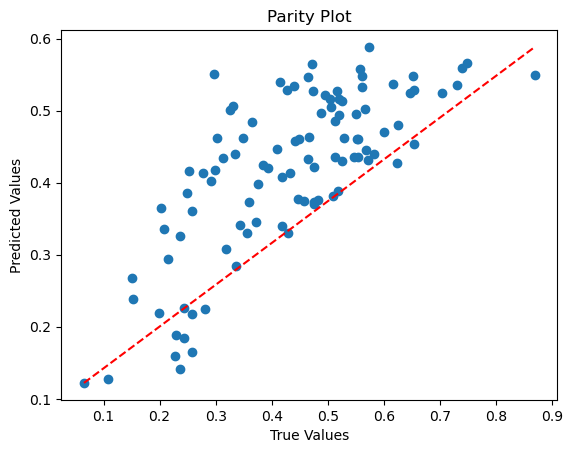

In [433]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red', linestyle='--') 
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

A handy output of Random Forest is feature importance. Now we can see which features are most important to our target variable.






In [434]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

<Figure size 1000x600 with 0 Axes>

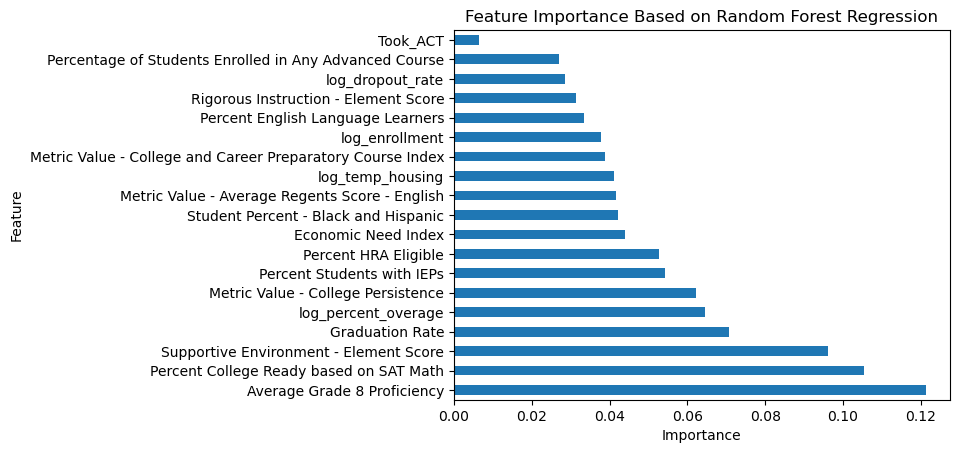

In [435]:
plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel('Importance')
plt.title('Feature Importance Based on Random Forest Regression')
plt.show()

**Results**: Our tuned Random Forest model performed slightly better than the original but did not outperform the LASSO regression. Nonetheless, we can still evaluate the feature importance from the Random Forest and compare it to previous models. Average Grade 8 Proficiency and Supportive Environment scores remain in the top 3 most important features. Additionally, 'Percent College Ready based on SAT Math' has emerged as a key feature. This suggests that SAT Math scores are an indicator of chronic absenteeism—students who attend school regularly are more likely to be college-ready based on their SAT performance.

### Gradient Boosting Regression

We will try one more regression algorithm to see if we can improve our results.

Unlike the previous bagging method, we will now employ a boosting technique. In boosting, trees are grown sequentially rather than in parallel, as in bagging. This approach uses random sampling with replacement over weighted data, enabling each tree to learn from the errors of the previous models. By aggregating these weak learners into a strong learner, boosting optimizes the overall model performance.

The important hyperparameters to tune in gradient boosting are learning rate (controls for the contribution of each tree), n_estimators (number of trees), max_depth (controls number of nodes in the tree), and max_features (number of features to consider for splits) [@noauthor_gradientboostingregressor_nodate]

In [501]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df_regression, 'Percent of Students Chronically Absent')

In [502]:
model = train(X_train, y_train, 'regression', 'gradient_boosting')
y_pred = validation_eval('regression', model,  X_val, y_val)

Mean Absolute Error (MAE): 0.0781
Root Mean Squared Error (RMSE): 0.0967
R-squared: 0.5203


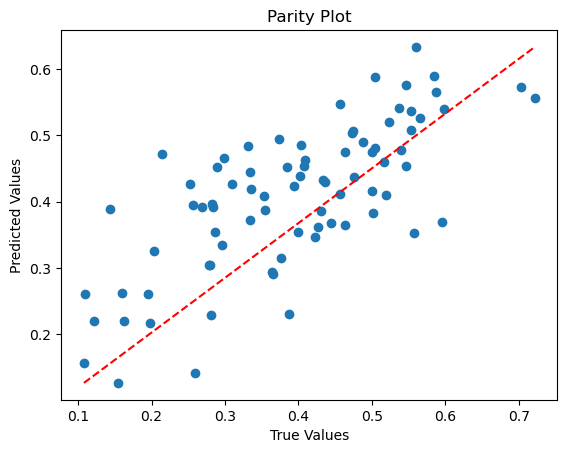

In [504]:
plt.scatter(y_val, y_pred)
plt.plot([min(y_val), max(y_val)], [min(y_pred), max(y_pred)], color='red', linestyle='--') 
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

In [503]:
model = tune(model, X_train, y_train, boost_param_grid, scoring='neg_mean_squared_error')

Best params: {'learning_rate': 0.05, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}


In [559]:
model = train(X_train, y_train, 'regression', 'gradient_boosting', learning_rate= 0.05, max_depth= 10, max_features= 'log2', n_estimators= 100)
print('Validation Scores')
y_pred = validation_eval('regression', model,  X_val, y_val)

Validation Scores
Mean Absolute Error (MAE): 0.0742
Root Mean Squared Error (RMSE): 0.0941
R-squared: 0.5461


In [558]:
print('Test Evaluation')
y_pred = evaluate_test('regression', model, X_test, y_test)

Test Evaluation
Mean Absolute Error (MAE): 0.0978
Root Mean Squared Error (RMSE): 0.1209
R-squared: 0.5147


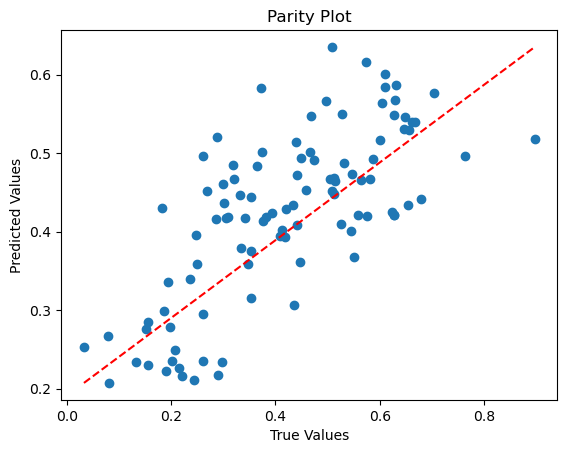

In [557]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='red', linestyle='--') 
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.show()

**Result**: The tuned gradient boosting model shows slight improvement over the original but does not perform as well on the test data. Both the LASSO and Random Forest Regression models outperformed it, suggesting that gradient boosting may not be the best fit for this dataset.

## Binary Classification

Binary classification is a supervised learning algorithm used for predicting categorical variables with two possible classes. The goal is to train a model that accurately predicts the correct class labels as much as possible. The output of a classification task is best evaluated using a confusion matrix, which provides insights into the model's performance. From the confusion matrix, we can calculate key metrics such as accuracy, precision, recall, and F1 score. The choice of the metric to maximize depends on the specific classification problem.

The calculations are as follows:
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
$$
\text{Precision} = \frac{TP}{TP + FP}
$$
$$
\text{Recall} = \frac{TP}{TP + FN}
$$
F1 is the harmonic balance of precision and recall, calculated as: 
$$
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Target variable:** *High Schools with high vs. low dropout risk*

In this case, accuracy is not an ideal metric because our classes are imbalanced. The worst-case scenario is failing to identify a school as having high dropout risk. If we treat the positive class as "high schools with high dropout risk," we aim to minimize false negatives (Type II errors) and maximize the recall score. To achieve this, we will use cross-validation to identify the algorithm that performs best for our objective.

First, we will create a binary variable for high dropout risk. High-risk schools will be defined as those in the 75th percentile or above of the dropout rate distribution. Additionally, we will exclude the "Graduation Rate" feature to avoid data leakage.

In [560]:
print(df_clean['dropout_rate'].describe())

count    501.000000
mean       0.053580
std        0.052614
min        0.000000
25%        0.012250
50%        0.037000
75%        0.077000
max        0.276500
Name: dropout_rate, dtype: float64


In [561]:
df_class = df_clean.copy()
df_class['high_dropout'] = [1 if x >= .077 else 0 for x in df_class['dropout_rate']]
df_class.drop(['dropout_rate','Graduation Rate'], axis=1, inplace=True)

### Random Forest Classification

We will begin by using a Random Forest classifier. This method is similar to the Random Forest regressor we explored earlier, but instead of predicting continuous variables, the trees now predict the class to which the data belongs. In Random Forest classification, the final prediction is determined by a majority vote among all the decision trees in the ensemble, rather than taking the average as in regression. 

Since our minorty class is imbalanced I will use SMOTE (Synthetic Minority Over-sampling Technique) to over sample the minority class. This will balance the data and create a more robust model.

In [566]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

In [567]:
smote = SMOTE(sampling_strategy='auto')
X_smote, y_smote = smote.fit_resample(X_train, y_train)

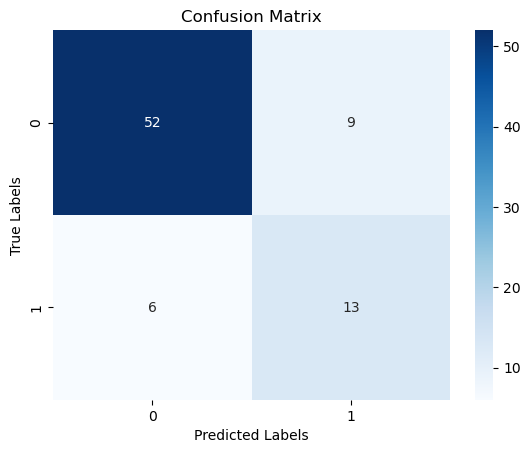

In [568]:
model = train(X_smote, y_smote, 'classification', 'random_forest')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [569]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.91      0.83      0.87        75
           1       0.61      0.77      0.68        26

    accuracy                           0.81       101
   macro avg       0.76      0.80      0.77       101
weighted avg       0.83      0.81      0.82       101



In [570]:
model = tune(model, X_train, y_train, rf_param_grid, scoring='f1')

Best params: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 50}


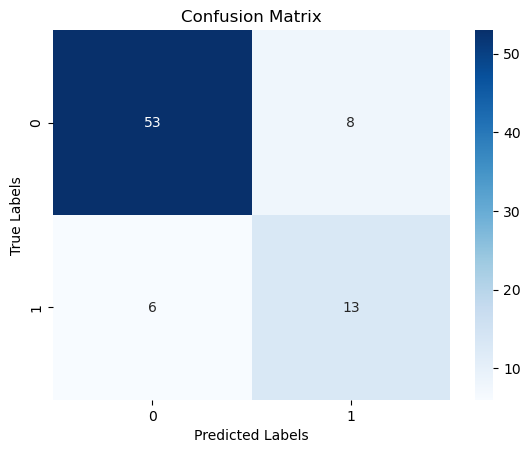

In [578]:
model = train(X_smote, y_smote, 'classification', 'random_forest', bootstrap=False, max_depth=15, max_features='sqrt', n_estimators=50)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [579]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.89      0.88      0.89        75
           1       0.67      0.69      0.68        26

    accuracy                           0.83       101
   macro avg       0.78      0.79      0.78       101
weighted avg       0.83      0.83      0.83       101



**Result:** The tuned Random Forest Classifier showed only a slight improvement upon the base model. Since we want to prioritize recall, to avoid overlooking schools with high dropout risk, this model correctly identifies 88% of schools with low dropout risk but only 69% of schools with high dropout risk. This suggests that there is room for improvement. Next, I will explore alternative classification algorithms to achieve better recall for high-risk schools.

### Gradient Boosting Classification

Next, we will use a Gradient Boosting Classifier. This method is similar to the Gradient Boosting Regressor we tried earlier, but instead of predicting continuous values, the trees are trained to classify the data into predefined classes.

In [582]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_class, target_column='high_dropout')

In [583]:
smote = SMOTE(sampling_strategy='auto')
X_smote, y_smote = smote.fit_resample(X_train, y_train)

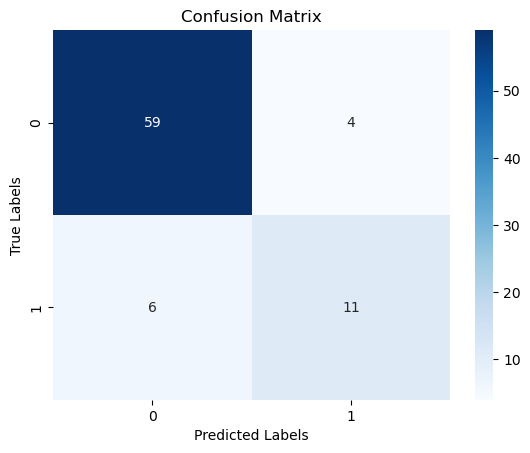

In [584]:
model = train(X_smote, y_smote, 'classification', 'gradient_boosting')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [585]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.96      0.89      0.92        79
           1       0.68      0.86      0.76        22

    accuracy                           0.88       101
   macro avg       0.82      0.87      0.84       101
weighted avg       0.90      0.88      0.89       101



In [596]:
model = tune(model, X_train, y_train, boost_param_grid, scoring='f1')

Best params: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}


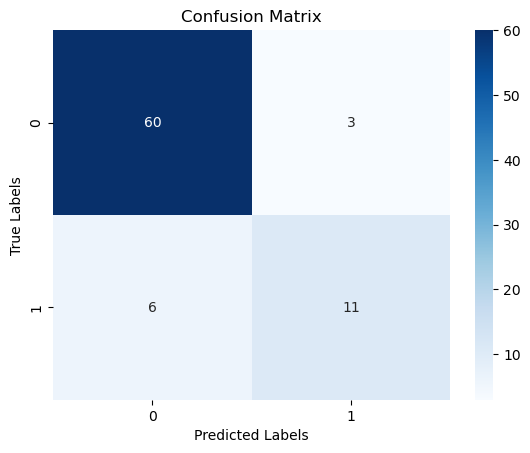

In [651]:
model = train(X_smote, y_smote, 'classification', 'gradient_boosting', learning_rate =0.2, max_depth=3, max_features='log2', n_estimators=100)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [652]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

           0       0.97      0.89      0.93        79
           1       0.69      0.91      0.78        22

    accuracy                           0.89       101
   macro avg       0.83      0.90      0.86       101
weighted avg       0.91      0.89      0.90       101



<Figure size 1000x600 with 0 Axes>

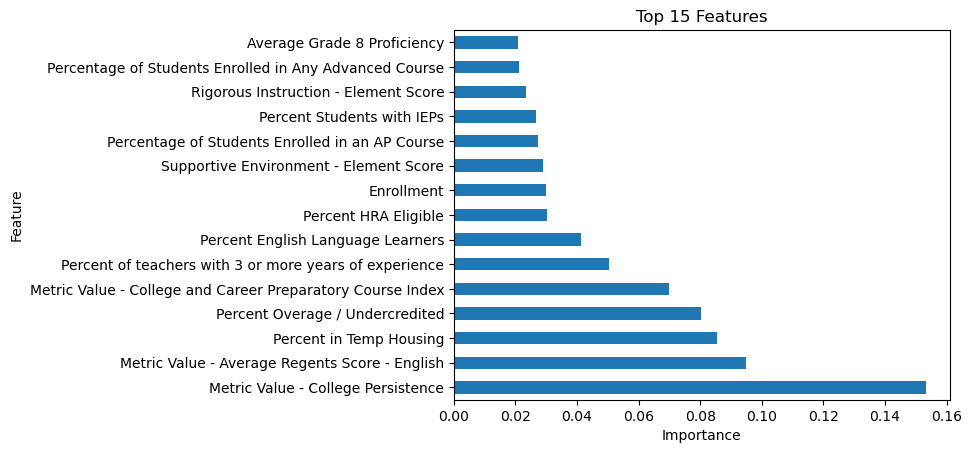

In [653]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel('Importance')
plt.title('Top 15 Features')
plt.show()

**Result:** The tuned gradient boosting model effectively predicts high and low dropout risk for high schools, outperforming the Random Forest model. Since we prioritize recall (to avoid overlooking schools with high dropout risk), this model performs well, correctly identifying 89% of schools with low dropout risk and 91% of schools with high dropout risk. These results suggest that it is possible to identify key drivers of dropout risk and intervene accordingly.

The top 15 important features highlight several key factors, with college persistence ranking the highest. This suggests that schools struggling with dropout risk may also have issues with retaining students after their first year of college. Other significant features include percent of students in temporary housing and percent of overage/undercredited students (students with very few credits), which indicates a strong relationship between socioeconomic challenges and dropout rates.

## Multiclass Classification

Multiclass classification is similar to binary classification, but instead of predicting between two classes, we are now predicting across three or more classes. In this case, we are interested in classifying high schools based on their rates of college persistence, which will be categorized as low, medium, or high.

In our binary classification, we focused on identifying high schools with a high dropout risk rate. However, even if a high school is deemed "safe" with low dropout risk, we still want to intervene if the school has low college persistence rates. While preventing high school dropout is a significant achievement, we also want these efforts to translate into preventing dropouts from higher education.

**Target Variable:** *College Persistence*

First, we will divide the college persistence distribution into three bins, labeling them as Low, Medium, and High. We will again use SMOTE to address class imbalance.

In [654]:
df_multi = df_clean.copy()
df_multi['college_persistence_ranking'] = pd.cut(df_multi['Metric Value - College Persistence'], bins=3, labels=['Low','Medium','High'])
df_multi.drop(['Metric Value - College Persistence'], axis=1, inplace=True)

### Random Forest Classifier
We will test how well a Random Forest Classifier predicts our labels, this time for three classes 

In [655]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_multi, target_column='college_persistence_ranking')

In [656]:
smote = SMOTE(sampling_strategy='auto')
X_smote, y_smote = smote.fit_resample(X_train, y_train)

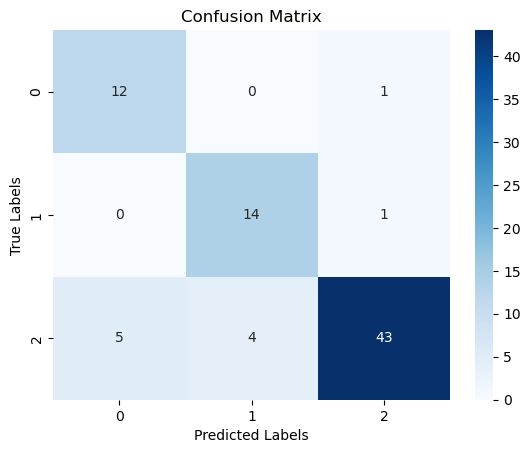

In [657]:
model = train(X_smote, y_smote, 'classification', 'random_forest')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [658]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.63      0.77      0.69        22
         Low       0.61      0.64      0.62        22
      Medium       0.75      0.67      0.70        57

    accuracy                           0.68       101
   macro avg       0.66      0.69      0.67       101
weighted avg       0.69      0.68      0.68       101



In [659]:
model = tune(model, X_train, y_train, rf_param_grid)

Best params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}


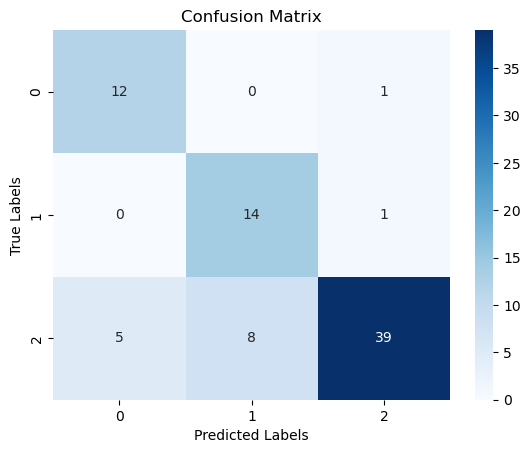

In [660]:
model = train(X_smote, y_smote, 'classification', 'random_forest', bootstrap=True, max_depth=5, max_features='sqrt', n_estimators=50)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [661]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.64      0.82      0.72        22
         Low       0.66      0.86      0.75        22
      Medium       0.84      0.65      0.73        57

    accuracy                           0.73       101
   macro avg       0.71      0.78      0.73       101
weighted avg       0.76      0.73      0.73       101



**Result:** The tuned Random Forest Classifier showed a slight improvement upon the base model in predicting instances of high and low rates of college persistence but performed worse for schools with medium rates, identifying only 65% of them. I hypothesize that similar to binary classification, the gradient boosted will improve upon this performance.

### Gradient Boosting

Now we will attempt a Gradient Boosting Classifier and see if it improves upon the Random Forest Classifier

In [662]:
X, y, X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(df = df_multi, target_column='college_persistence_ranking')

In [663]:
smote = SMOTE(sampling_strategy='auto')
X_smote, y_smote = smote.fit_resample(X_train, y_train)

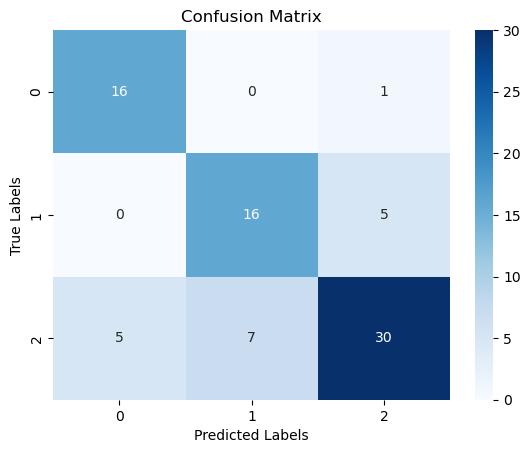

In [664]:
model = train(X_smote, y_smote, 'classification', 'gradient_boosting')
y_pred = validation_eval('classification',model,  X_val, y_val)

In [665]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.55      0.86      0.67        14
         Low       0.61      0.86      0.72        22
      Medium       0.90      0.66      0.76        65

    accuracy                           0.73       101
   macro avg       0.68      0.79      0.71       101
weighted avg       0.79      0.73      0.74       101



In [666]:
model = tune(model, X_train, y_train, boost_param_grid)

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}


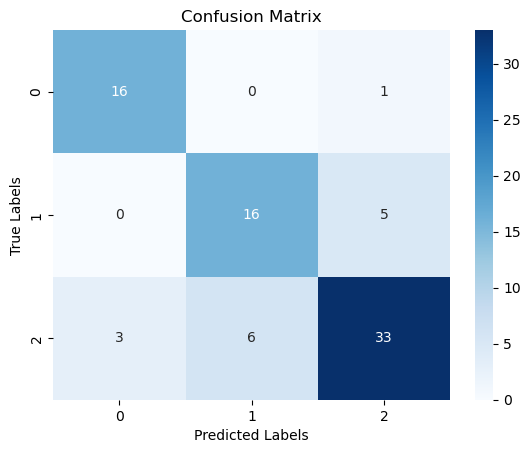

In [672]:
model = train(X_smote, y_smote, 'classification', 'gradient_boosting', learning_rate = 0.05, max_depth=3, max_features='sqrt', n_estimators=100)
y_pred = validation_eval('classification', model,  X_val, y_val)

In [673]:
y_pred = evaluate_test('classification', model, X_test, y_test)

Classification Report:               precision    recall  f1-score   support

        High       0.60      0.86      0.71        14
         Low       0.67      0.91      0.77        22
      Medium       0.92      0.72      0.81        65

    accuracy                           0.78       101
   macro avg       0.73      0.83      0.76       101
weighted avg       0.82      0.78      0.79       101



<Figure size 1000x600 with 0 Axes>

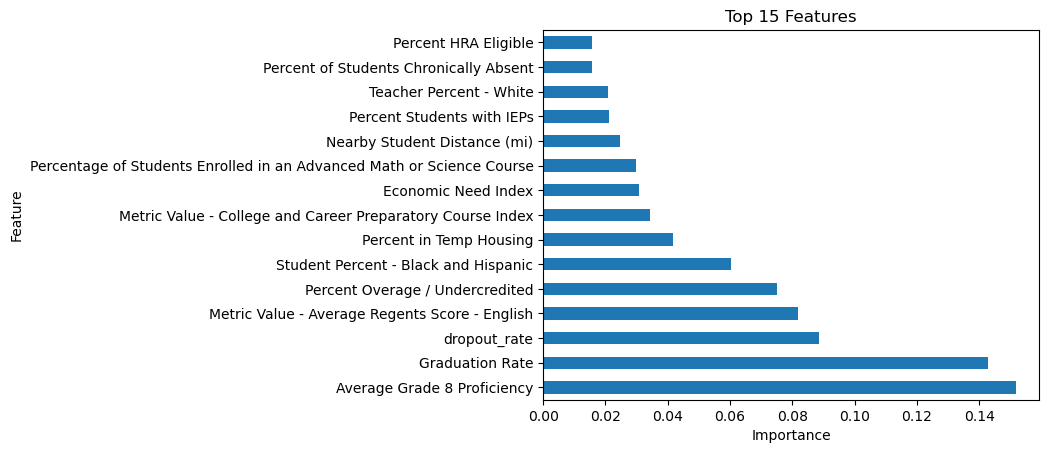

In [674]:
feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel('Importance')
plt.title('Top 15 Features')
plt.show()

**Result** Examining the recall scores, this gradient boosting multiclass classification model successfully predicts 86% of schools with high college persistence, 72% of schools with medium college persistence, and 91% of schools with low college persistence. While there is room for improvement in predicting the medium category, the model's ability to accurately identify schools with low college persistence is particularly significant, as this is where where intervention is most needed. This model performed better than the Random Forest Classifier

Looking at the feature importance, as we saw in the regression on chronic absenteeism model, Average Grade 8 Proficiency is the most important driver of college persistence. It is noteworthy that this metric continues to have predictive power at the college level. Additionally, both dropout rate and the percentage of chronically absent students are significant features in this model, highlighting the deep-rooted issues within schools that must be addressed.

### Conclusion

The results across all models provide consistent and valuable insights into the factors driving student outcomes such as chronic absenteeism, dropout risk, and college persistence in high schools. Key predictors include Average Grade 8 Proficiency, Supportive Environment score, and Rigorous Instruction score were found in multiple models, showing the importance of academic foundations, school culture, and quality instruction. Socioeconomic indicators, such as the Percent of Students in Temporary Housing, Percent of English Language Learners, and Percent of Overage/Undercredited Students, further emphasize the impact of systemic challenges on educational outcomes.

Model Summary:
* Regression: LASSO performed best, with a 61% fit and outperforming Random Forest and Gradient Boosting models.
* Binary Classification: The Gradient Boosting model effectively identified 91% of schools with high dropout risk.
* Multiclass Classification: The Gradient Boosting multiclass model accurately predicted 86% of schools with high college persistence and 91% of schools with low college persistence, where intervention is most critical. 
    * *Note:* Random Forest models showed slight improvements with tuning, but underperformed compared to Gradient Bosting. 

In conclusion, these results highlight actionable insights for improving student outcomes. We need to strengthen academic foundations in early education, foster supportive school environments, and address socioeconomic challenges. Models with strong recall, can serve as valuable tools for identifying schools in need of intervention and targeting resources where they are most needed.